# Warning : 
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.

# 0) Loading MNIST data

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

torch.Size([100, 1, 28, 28])
torch.Size([100])


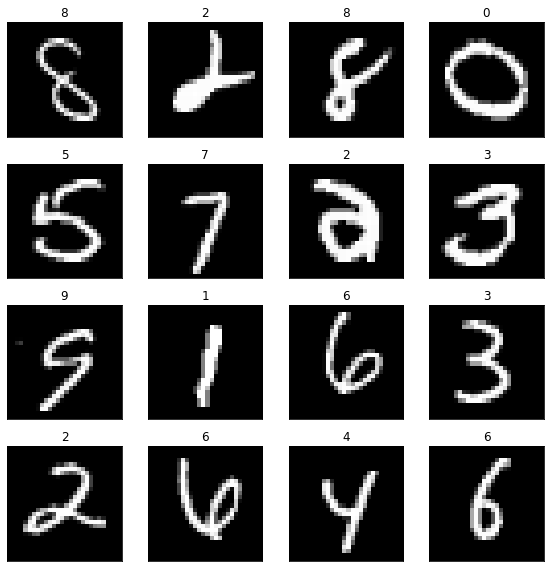

In [3]:
# Load MNIST dataset
bsize = 100
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True)#, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=bsize)#, **kwargs)

# Visualize some images
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)
fig, axes = plt.subplots(nrows=4, ncols=4)
for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 16:
        break
    axes[i // 4][i % 4].imshow(images[i][0], cmap='gray')
    axes[i // 4][i % 4].set_title(f"{label}")
    axes[i // 4][i % 4].set_xticks([])
    axes[i // 4][i % 4].set_yticks([])
fig.set_size_inches(8, 8)
fig.tight_layout()

# 1) Classification Models

## 1.A) Let us define a Logistic regression model

In [4]:
class LR(nn.Module):
  def __init__(self):
    super(LR, self).__init__()
    # YOUR CODE
    self.fc1 = nn.Linear(28*28, 10)

  def forward(self, x):
    # YOUR CODE
    x = x.view(-1, 28 * 28)

    return self.fc1(x)
  
class Net(nn.Module):
    def __init__(self, name, data_Height, data_Width, n_hidden=100, n_layers=1, activation=nn.ReLU):
        super(Net, self).__init__()
        self.name = name
        self.activation = activation()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(data_Height*data_Width, n_hidden))
        for i in range(n_layers-1):
            self.layers.append(nn.Linear(n_hidden, n_hidden))
        self.layers.append(nn.Linear(n_hidden, 10))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        x = self.softmax(x)
        return x

In [5]:
#print(images.shape[-1], images.shape[-2])
lr = LR().to(device)
print(lr)

pred = lr(images.to(device))
print(pred.shape)

LR(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)
torch.Size([100, 10])


## Lets train the LR model!

In [6]:
optimizer = torch.optim.SGD(lr.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
nbepochs = 3

for e in range(nbepochs):
  total_loss, correct = 0.0, 0.0
  for (images, labels) in train_loader: 
    # ZERO GRAD
    optimizer.zero_grad()
    
    im, lab = images.to(device), labels.to(device)
    # FORWARD : YOUR CODE
    pred = lr(im)
    # LOSS COMPUTATION : YOUR CODE
    loss = criterion(pred, lab)
    total_loss += loss
    correct += (pred.argmax(-1) == lab).sum()
    
    # BACKWARD + GRADIENT STEP : YOUR CODE
    loss.backward()
    optimizer.step()


  print(f"[Epoch {e + 1:2d}] loss: {total_loss/ len(train_dataset):.2E} accuracy_train: {correct / len(train_dataset):.2%}")


[Epoch  1] loss: 3.71E-03 accuracy_train: 89.09%
[Epoch  2] loss: 3.03E-03 accuracy_train: 91.37%
[Epoch  3] loss: 2.94E-03 accuracy_train: 91.66%


In [7]:
def evalTest(testloader, net):
  total_loss, nbSamples, correct=0.0, 0.0, 0.0

  for (images, labels) in testloader: 
    optimizer.zero_grad()
    
    im, lab = images.to(device), labels.to(device)
    pred = net(im)

    loss = criterion(pred, lab)
    total_loss += loss
    correct += (pred.argmax(-1) == lab).sum()
    nbSamples += images.shape[0]

  acc = correct / nbSamples*100.0
  return acc, total_loss / nbSamples

In [8]:
accT= evalTest(test_loader, lr)[0]
print(f"Test accuracy={accT:.2f}%")

Test accuracy=91.95%


## 1.B) Let's now define a MLP with a single hidden layer of size 100

In [20]:
class SimpleMLP(nn.Module):
  def __init__(self):
    super(SimpleMLP, self).__init__()
    # YOUR CODE
    self.fc1 = nn.Linear(28*28, 100)
    self.fc2 = nn.Linear(100, 10)


  def forward(self, x):
    # YOUR CODE
    x = x.view(-1, 28*28)
    h = F.relu(self.fc1(x))

    return self.fc2(h)

class Net(nn.Module):
    def __init__(self, name, data_Height, data_Width, n_hidden=100, n_layers=1, activation=nn.ReLU):
        super(Net, self).__init__()
        self.name = name
        self.activation = activation()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(data_Height*data_Width, n_hidden))
        for i in range(n_layers-1):
            self.layers.append(nn.Linear(n_hidden, n_hidden))
        self.layers.append(nn.Linear(n_hidden, 10))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        x = self.softmax(x)
        return x

## Lets train the MLP model!

In [21]:
mlp = SimpleMLP().to(device)

In [22]:
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
nbepochs = 20

for e in range(nbepochs):
  total_loss, correct = 0.0, 0.0
  for (images, labels) in train_loader: 
    # ZERO GRAD
    optimizer.zero_grad()
    
    im, lab = images.to(device), labels.to(device)
    # FORWARD : YOUR CODE
    pred = mlp(im)
    # LOSS COMPUTATION : YOUR CODE
    loss = criterion(pred, lab)
    total_loss += loss
    correct += (pred.argmax(-1) == lab).sum()
    
    # BACKWARD + GRADIENT STEP : YOUR CODE
    loss.backward()
    optimizer.step()


  print(f"[Epoch {e + 1:2d}] loss: {total_loss/ len(train_dataset):.2E} accuracy_train: {correct / len(train_dataset):.2%}")

[Epoch  1] loss: 3.07E-03 accuracy_train: 91.21%
[Epoch  2] loss: 1.47E-03 accuracy_train: 95.74%
[Epoch  3] loss: 1.05E-03 accuracy_train: 96.93%
[Epoch  4] loss: 8.37E-04 accuracy_train: 97.53%
[Epoch  5] loss: 6.88E-04 accuracy_train: 97.97%
[Epoch  6] loss: 5.74E-04 accuracy_train: 98.34%
[Epoch  7] loss: 4.87E-04 accuracy_train: 98.59%
[Epoch  8] loss: 4.17E-04 accuracy_train: 98.79%
[Epoch  9] loss: 3.65E-04 accuracy_train: 98.95%
[Epoch 10] loss: 3.11E-04 accuracy_train: 99.13%
[Epoch 11] loss: 2.75E-04 accuracy_train: 99.27%
[Epoch 12] loss: 2.37E-04 accuracy_train: 99.43%
[Epoch 13] loss: 2.03E-04 accuracy_train: 99.51%
[Epoch 14] loss: 1.81E-04 accuracy_train: 99.61%
[Epoch 15] loss: 1.58E-04 accuracy_train: 99.66%
[Epoch 16] loss: 1.40E-04 accuracy_train: 99.75%
[Epoch 17] loss: 1.21E-04 accuracy_train: 99.80%
[Epoch 18] loss: 1.05E-04 accuracy_train: 99.87%
[Epoch 19] loss: 9.44E-05 accuracy_train: 99.88%
[Epoch 20] loss: 8.21E-05 accuracy_train: 99.92%


In [23]:
accT= evalTest(test_loader, mlp)[0]
print(f"Test accuracy={accT:.2f}%")

Test accuracy=97.90%


## 1.C) Let's now define a ConvNet with a two [Conv + Pool] layers and one hidden layer: 


1.   Conv1: 16 filters of size 5x5, no padding ('valid)'
  - ReLU
  - Pool1: MaxPool2d, stride 2
2.   Conv2: 32 filters of size 5x5, no padding 
  - ReLU
  - Pool1: MaxPool2d, stride 2
3. One fully connected layer of size 100 (flatteing before applying it)
3. One fully connected layer of size 10 (number of classes)


In [47]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    #nn.ConvD2(#dimensions(niveau de gris/1 ou rgb/3 ?), #filtres, #taille des filtres)
    self.conv1 = nn.Conv2d(1, 16, 5, padding='valid')
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=(2, 2))
    self.conv2 = nn.Conv2d(16, 32, 5, padding='valid')
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=(2, 2))
    self.fc1 = nn.Linear(512, 100)
    self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    # YOUR CODE
    # Conv1
    h = F.relu(self.conv1(x))
    h = self.maxpool1(h)
    # Conv2
    h = F.relu(self.conv2(h))
    h = self.maxpool2(h)
    # Flattening = Vectoriser
    h = h.view(-1, 4*4*32)

    # fully connected
    h = F.relu(self.fc1(h))
        
    return self.fc2(h)


  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
      
    return num_features
    
  
class Net(nn.Module):
    def __init__(self, name, data_Height, data_Width, n_hidden=100, n_layers=1, activation=nn.ReLU):
        super(Net, self).__init__()
        self.name = name
        self.activation = activation()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(data_Height*data_Width, n_hidden))
        for i in range(n_layers-1):
            self.layers.append(nn.Linear(n_hidden, n_hidden))
        self.layers.append(nn.Linear(n_hidden, 10))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        x = self.softmax(x)
        return x

In [48]:
def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [49]:
lenet = LeNet().to(device)
print(lenet)

npar = count_parameters(lenet)
print(f"number of parameters in lenet ={npar :d}")

LeNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (maxpool1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (maxpool2): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
number of parameters in lenet =65558


## Lets train the ConvNet!

In [50]:
optimizer = torch.optim.SGD(lenet.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
nbepochs = 20
# TRAINING LOOP: YOUR CODE 
for e in range(nbepochs):
  total_loss, correct = 0.0, 0.0
  for (images, labels) in train_loader: 
    # ZERO GRAD
    optimizer.zero_grad()
    
    im, lab = images.to(device), labels.to(device)
    # FORWARD : YOUR CODE
    pred = lenet(im)
    # LOSS COMPUTATION : YOUR CODE
    loss = criterion(pred, lab)
    total_loss += loss
    correct += (pred.argmax(-1) == lab).sum()
    
    # BACKWARD + GRADIENT STEP : YOUR CODE
    loss.backward()
    optimizer.step()


  print(f"[Epoch {e + 1:2d}] loss: {total_loss/ len(train_dataset):.2E} accuracy_train: {correct / len(train_dataset):.2%}")


[Epoch  1] loss: 2.45E-03 accuracy_train: 92.35%
[Epoch  2] loss: 5.88E-04 accuracy_train: 98.16%
[Epoch  3] loss: 4.01E-04 accuracy_train: 98.74%
[Epoch  4] loss: 3.16E-04 accuracy_train: 99.00%
[Epoch  5] loss: 2.50E-04 accuracy_train: 99.22%
[Epoch  6] loss: 1.98E-04 accuracy_train: 99.40%
[Epoch  7] loss: 1.69E-04 accuracy_train: 99.49%
[Epoch  8] loss: 1.34E-04 accuracy_train: 99.56%
[Epoch  9] loss: 1.16E-04 accuracy_train: 99.65%
[Epoch 10] loss: 9.41E-05 accuracy_train: 99.72%
[Epoch 11] loss: 7.79E-05 accuracy_train: 99.79%
[Epoch 12] loss: 6.25E-05 accuracy_train: 99.83%
[Epoch 13] loss: 5.01E-05 accuracy_train: 99.88%
[Epoch 14] loss: 4.76E-05 accuracy_train: 99.87%
[Epoch 15] loss: 3.52E-05 accuracy_train: 99.92%
[Epoch 16] loss: 2.08E-05 accuracy_train: 99.96%
[Epoch 17] loss: 2.03E-05 accuracy_train: 99.96%
[Epoch 18] loss: 2.09E-05 accuracy_train: 99.95%
[Epoch 19] loss: 1.29E-05 accuracy_train: 99.97%
[Epoch 20] loss: 1.24E-05 accuracy_train: 99.97%


In [51]:
accT= evalTest(test_loader, lenet)[0]
print(f"Test accuracy={accT:.2f}%")

Test accuracy=99.25%


# 2) Manifold untangling

## Let's get the full test data 

In [52]:
import numpy as np 

X_test = np.zeros((10000,784))
Y_test = np.zeros((10000,))

bsize=100

for id, (images, labels) in enumerate(test_loader): 
    X_test[id*bsize:id*bsize+bsize,:] = images.view(-1,784)
    Y_test[id*bsize:id*bsize+bsize] = labels

## 2.A) t-SNE on raw data

In [61]:
from sklearn.manifold import TSNE

import matplotlib.cm as cm
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.mixture import GaussianMixture
from scipy import linalg
from sklearn.neighbors import NearestNeighbors

# TSNE: creation + call fit_transform to get the 2D projection X_r
tsne = TSNE(n_components=2, perplexity=30, init='pca')
X_r = tsne.fit_transform(X_test)

In [62]:
def best_ellipses(points, labels):
  # computing best fiiting ellipse for a set of points with asscoiated labels
  gaussians = []
  for i in range(10):
    gaussians.append(GaussianMixture(n_components=1, covariance_type='full').fit(points[labels==i, :]))
  return gaussians

def neighboring_hit(points, labels):
  k = 6
  nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(points)
  distances, indices = nbrs.kneighbors(points)

  txs = 0.0
  txsc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  nppts = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

  for i in range(len(points)):
    tx = 0.0
    for j in range(1,k+1):
      if (labels[indices[i,j]]== labels[i]):
        tx += 1
    tx /= k
    txsc[int(labels[i])] += tx
    nppts[int(labels[i])] += 1
    txs += tx

  for i in range(10):
    txsc[i] /= nppts[i]

  return txs / len(points)

In [63]:
# computing best fitting ellipses
ellipses = best_ellipses(X_r, Y_test)
# computing nh
nh = neighboring_hit(X_r, Y_test)

In [64]:
def visualization(points2D, labels, ellipses, nh):
    points2D_c= []
    for i in range(10):
        points2D_c.append(points2D[labels==i, :])
    # Data Visualization
    cmap =cm.tab10
    
    plt.figure(figsize=(8, 4), dpi=200)
    plt.set_cmap(cmap)
    plt.subplots_adjust(hspace=0.4 )
    plt.subplot(121)
    plt.scatter(points2D[:,0], points2D[:,1], c=labels,  s=3,edgecolors='none', cmap=cmap, alpha=1.0)
    plt.colorbar(ticks=range(10))
    plt.title("2D t-SNE - NH="+str(nh*100.0))
    
    vals = [ i/10.0 for i in range(10)]
    
    def plot_results(X, Y_, means, covariances, index, title, color):
        splot = plt.subplot(1, 2, 2)
        for i, (mean, covar) in enumerate(zip(means, covariances)):
            v, w = linalg.eigh(covar)
            v = 2. * np.sqrt(2.) * np.sqrt(v)
            u = w[0] / linalg.norm(w[0])
            # as the DP will not use every component it has access to
            # unless it needs it, we shouldn't plot the redundant
            # components.
            if not np.any(Y_ == i):
              continue
            plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color, alpha = 0.2)

            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180. * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
            ell.set_clip_box(splot.bbox)
            ell.set_alpha(0.6)
            splot.add_artist(ell)

        plt.title(title)

    for i in range(10):
        plot_results(points2D[labels==i, :], ellipses[i].predict(points2D[labels==i, :]), ellipses[i].means_, ellipses[i].covariances_, 0,"t-SNE fitting ellipses", cmap(vals[i]))

    #plt.savefig(projname+".png", dpi=100)
    plt.show()

<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positio

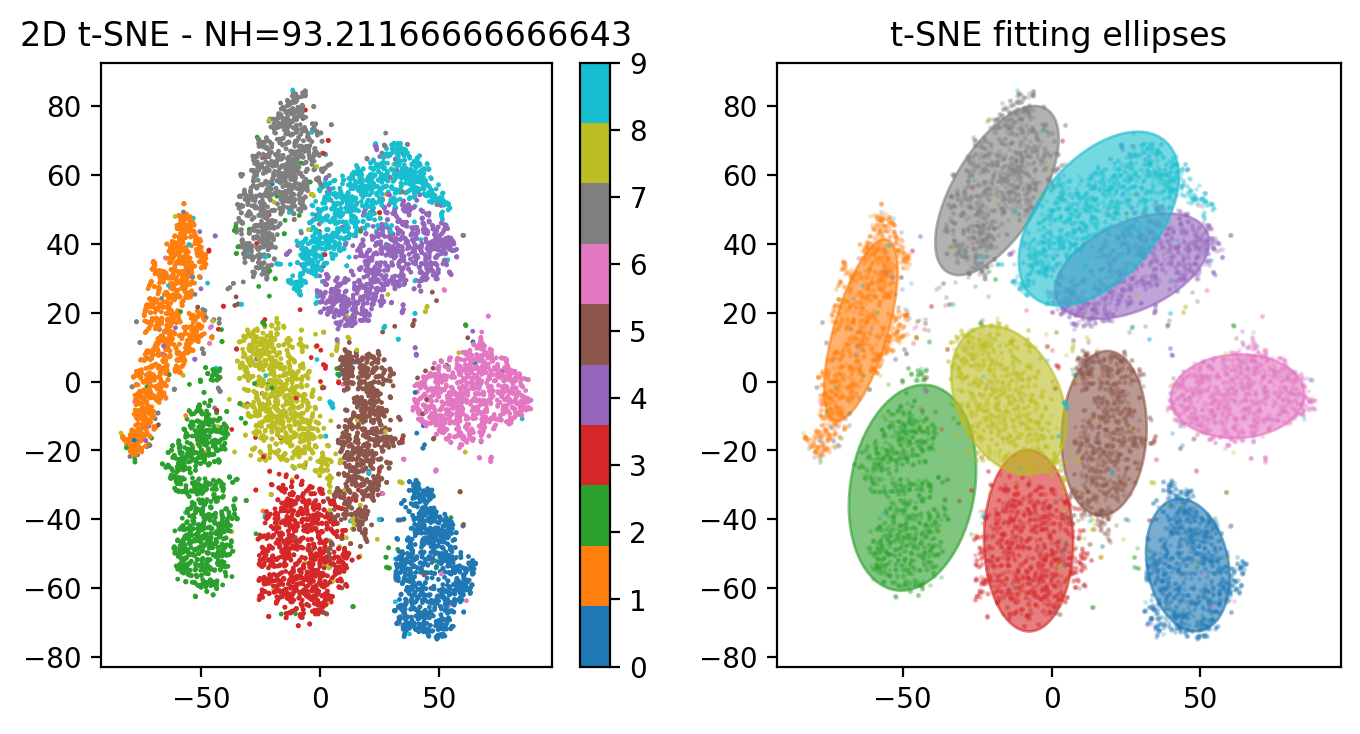

In [65]:
import matplotlib as mpl
visualization(X_r, Y_test, ellipses, nh)

**QUESTION:** what wan you conclude from the t-SNE visualization?

it is able to find a space where data points are well seperated

## 2.B) t-SNE on latent space from MLP

## The code below enables to extract a latent vector instead of the output prediction, as follows

In [66]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [67]:
mlp.fc1.register_forward_hook(get_activation('fc1'))

H_test_MLP = np.zeros((10000,100))

bsize=100

for id, (images, labels) in enumerate(test_loader): 
    output = mlp(images.to(device))
    H_test_MLP[id*bsize:id*bsize+bsize,:] = activation['fc1'].cpu().numpy()

In [69]:
# Compute t-SNE on H_test_MLP
H_r= TSNE(n_components=2, perplexity=30, init='pca').fit_transform(H_test_MLP)

<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positio

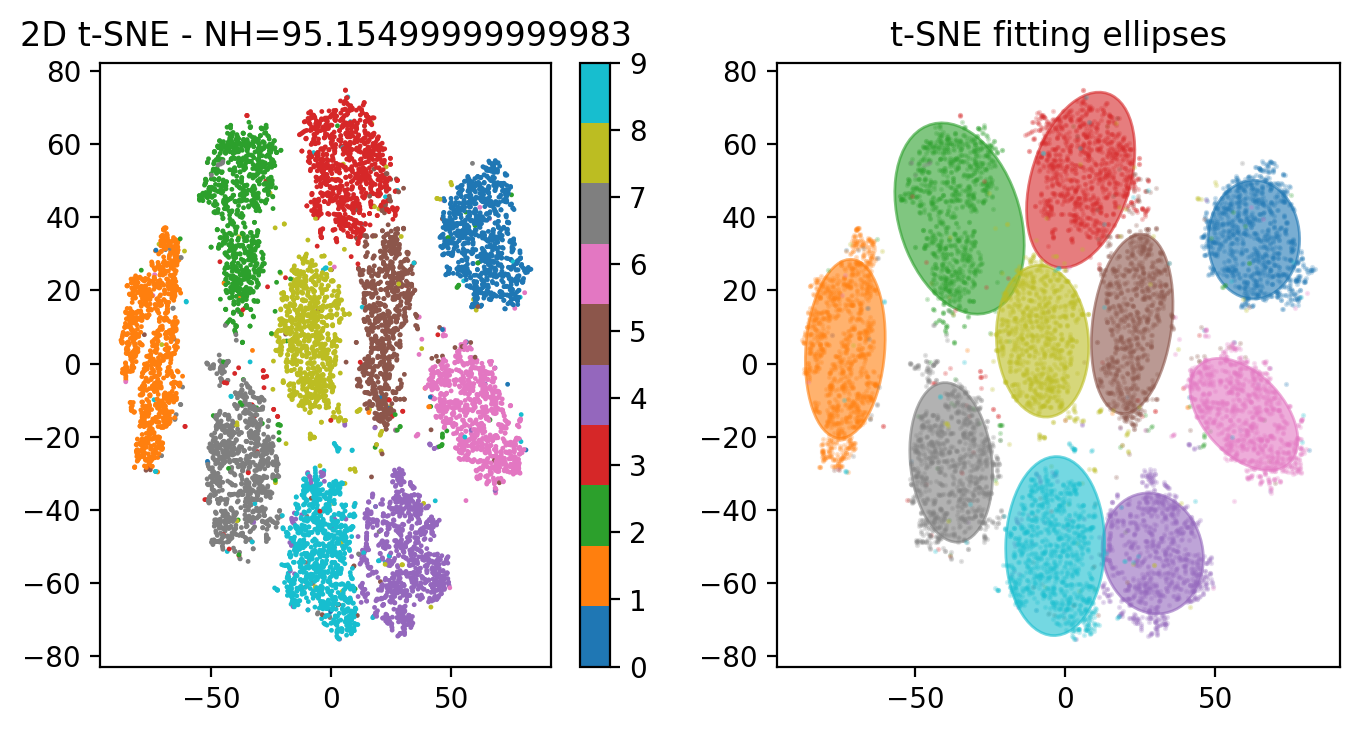

In [72]:
# computing best fitting ellipses
ellipses = best_ellipses(H_r, Y_test)
# computing nh
nh = neighboring_hit(H_r, Y_test)
# t-SNE visualization
visualization(H_r, Y_test, ellipses , nh)

## 2.C) t-SNE on latent space from ConvNet

<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
<ipython-input-64-eb696c1984f0>:34: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positio

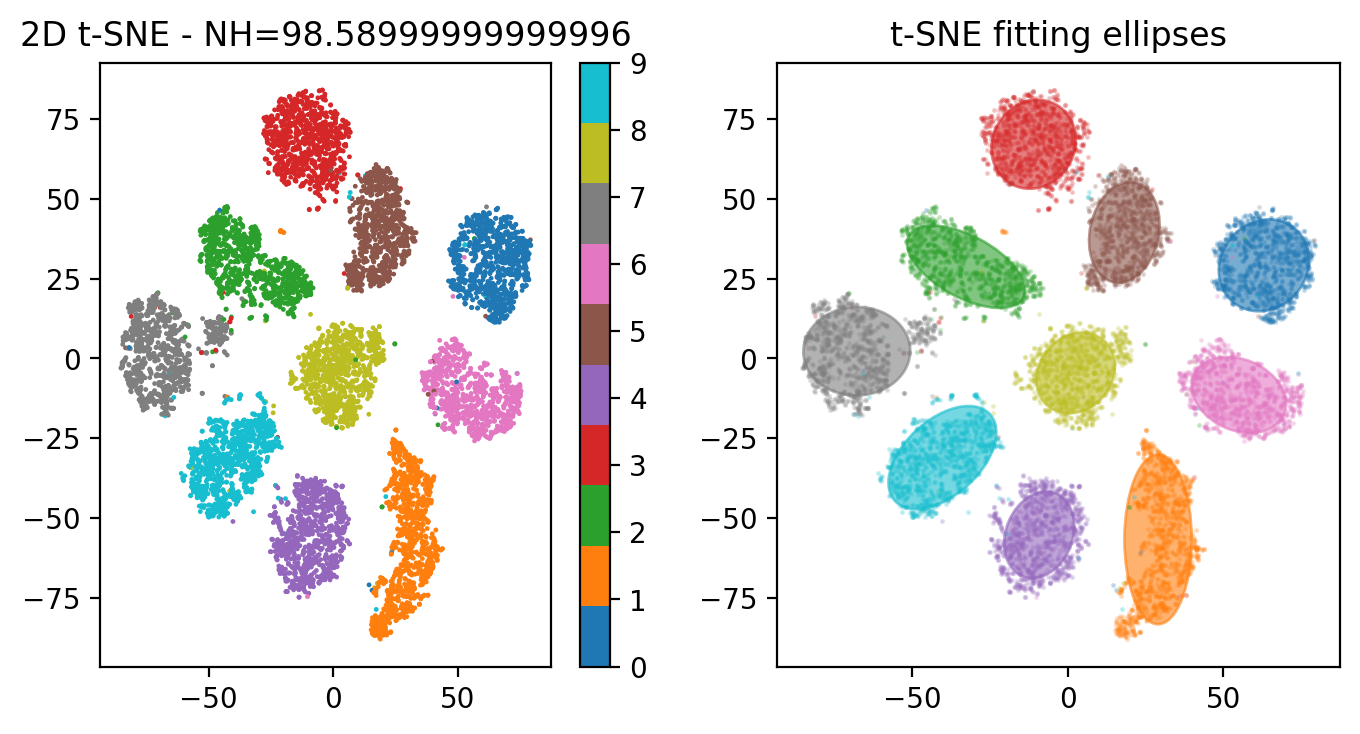

In [73]:
# Do the same for the ConvNet
# Latent 'fc1' feature extraction
lenet.fc1.register_forward_hook(get_activation('fc1'))

H_test_Conv = np.zeros((10000,100))

bsize=100

for id, (images, labels) in enumerate(test_loader): 
    output = lenet(images.to(device))
    H_test_Conv[id*bsize:id*bsize+bsize,:] = activation['fc1'].cpu().numpy()
# TSNE
# Compute t-SNE on H_test_MLP
H_r= TSNE(n_components=2, perplexity=30, init='pca').fit_transform(H_test_Conv)
# Visualization
# computing best fitting ellipses
ellipses = best_ellipses(H_r, Y_test)
# computing nh
nh = neighboring_hit(H_r, Y_test)
# t-SNE visualization
visualization(H_r, Y_test, ellipses , nh)